# Application with new data

This tutorial demonstrates deconvolution on new ST PDAC data using SODB and Tangram.

This tutorial refers to the following tutorial at https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_tangram.html. At the same time, the way of loadding data is modified by using SODB.

（需要增加单细胞数据链接）

## Import packages and set configurations

In [1]:
# Import several Python packages, including:
# scanpy: a Python package for single-cell RNA sequencing analysis
import scanpy as sc
# squidpy: a Python package for spatial transcriptomics analysis
import squidpy as sq
# numpy: a Python package for scientific computing with arrays
import numpy as np
# pandas: a Python package for data manipulation and analysis
import pandas as pd
# anndata: a Python package for handling annotated data objects in genomics
import anndata as ad
# pathlib: a Python module for working with file system paths
import pathlib
# matplotlib: a Python plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl
# skimage: a Python package for image processing
import skimage

In [14]:
# Import tangram for spatial deconvolution
import tangram as tg

In [86]:
# Print a header message, and the version of the squidpy and tangram packages
sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
print(f"tangram=={tg.__version__}")

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.2 pynndescent==0.5.8
squidpy==1.2.3
tangram==1.0.3


## Load a single cell dataset

In [2]:
# Use read_csv to load "pd_sc" and "pd_sc_meta"
pd_sc = pd.read_csv('data/pdac/sc_data.csv')
pd_sc_meta = pd.read_csv('data/pdac/sc_meta.csv')

In [3]:
# Set index using the 'Unnamed: 0' column for "pd_sc"
pd_sc = pd_sc.set_index('Unnamed: 0')

In [4]:
# Set index using the 'Cell' column for "pd_sc_meta"
pd_sc_meta = pd_sc_meta.set_index('Cell')

In [5]:
# Converte pandas's dataframes into numpy arrays
sc_genes = np.array(pd_sc.index)
sc_obs = np.array(pd_sc.columns)
# Transpose array
sc_X = np.array(pd_sc.values).transpose()

In [6]:
# Initialize an AnnData object using "sc_X", "sc_genes" and "sc_obs"
adata_sc = ad.AnnData(sc_X)
adata_sc.var_names = sc_genes
adata_sc.obs_names = sc_obs
# Assign the cell type labels to "adata_sc.obs['CellType']"
adata_sc.obs['CellType'] = pd_sc_meta['Cell_type'].values

/tmp/ipykernel_119901/662840930.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sc = ad.AnnData(sc_X)


In [7]:
# Print out the metadata of adata_sc
adata_sc

AnnData object with n_obs × n_vars = 1926 × 19104
    obs: 'CellType'

## Streamline development of loading spatial data with SOBD

In [8]:
# Import pysodb package
# Pysodb is a Python package that provides a set of tools for working with SODB databases. 
# SODB is a format used to store data in memory-mapped files for efficient access and querying. 
# This package allows users to interact with SODB files using Python.
import pysodb

In [9]:
# Initialization
sodb = pysodb.SODB()

In [10]:
# Define the name of the dataset_name and experiment_name
dataset_name = 'moncada2020integrating'
experiment_name = 'GSM3036911_spatial_transcriptomics'
# Load a specific experiment
# It takes two arguments: the name of the dataset and the name of the experiment to load.
# Two arguments are available at https://gene.ai.tencent.com/SpatialOmics/.
adata_st = sodb.load_experiment(dataset_name,experiment_name)

download experiment[GSM3036911_spatial_transcriptomics] in dataset[moncada2020integrating]


100%|██████████| 25.4M/25.4M [00:13<00:00, 2.00MB/s]


load experiment[GSM3036911_spatial_transcriptomics] in dataset[moncada2020integrating]


## Preparation

In [11]:
# Perform differential gene expression analysis across 'CellType' in 'adata_sc'
sc.tl.rank_genes_groups(adata_sc, groupby="CellType", use_raw=False)

In [12]:
# Create a Pandas DataFrame called "markers_df" by extracting the top 100 differentially expressed genes from 'adata_sc'
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
# Create a NumPy array called "genes_sc" by extracting the unique values from the "value" column of a melted version of the "markers_df" 
genes_sc = np.unique(markers_df.melt().value.values)
# Extracte the names of genes from "adata_st"
genes_st = adata_st.var_names.values
# Creates a Python list called "genes" 
# Contain the intersection of genes identified as differentially expressed in  "genes_sc" and genes detected in "genes_st".
genes = list(set(genes_sc).intersection(set(genes_st)))
# The length of "genes"
len(genes)

1133

## Perform Tangram for alignment

In [15]:
# Use the Tangram to align the gene expression profiles of "adata_sc" and "adata_st" based on the shared set of genes identified by the intersection of "genes_sc" and "genes_st".
tg.pp_adatas(adata_sc, adata_st, genes=genes)

INFO:root:1098 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:13775 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [16]:
# Use the map_cells_to_space function from the tangram to map cells from "adata_sc")" onto "adata_st". 
# The mapping use "cells" mode, which assign each cell from adata_sc to a location within the spatial transcriptomics space based on its gene expression profile.
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="cells",
    # target_count=adata_st.obs.cell_count.sum(),
    # density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
    device="cpu",
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1098 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.293, KL reg: 0.029
Score: 0.548, KL reg: 0.001
Score: 0.550, KL reg: 0.001
Score: 0.551, KL reg: 0.001
Score: 0.551, KL reg: 0.001
Score: 0.551, KL reg: 0.001
Score: 0.551, KL reg: 0.001
Score: 0.551, KL reg: 0.001
Score: 0.551, KL reg: 0.001
Score: 0.551, KL reg: 0.001


INFO:root:Saving results..


In [17]:
# Project "CellType" annotations from a single-cell RNA sequencing (scRNA-seq) dataset onto a spatial transcriptomics dataset, based on a previously computed cell-to-space mapping
tg.project_cell_annotations(ad_map, adata_st, annotation="CellType")

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [18]:
# Create new columns in "adata_st.obs" that correspond to the values in "adata_st.obsm['tangram_ct_pred']"
for ct in adata_st.obsm['tangram_ct_pred'].columns:
    adata_st.obs[ct] = np.array(adata_st.obsm['tangram_ct_pred'][ct].values)

In [19]:
# Print adata_st.obsm['tangram_ct_pred']
adata_st.obsm['tangram_ct_pred']

,Acinar cells,Ductal,Cancer clone A,Cancer clone B,mDCs,Tuft cells,pDCs,Endocrine cells,Endothelial cells,Macrophages,Mast cells,T cells NK cells,Monocytes,RBCs,Fibroblasts
spots,,,,,,,,,,,,,,,
10x10,0.006444,4.729997,0.110092,0.395633,0.496347,0.013628,0.054951,0.005291,0.094123,0.333470,0.052907,0.180649,0.056653,0.026625,0.037472
10x13,0.002064,4.798337,0.283907,0.073102,0.127184,0.064640,0.024021,0.005458,0.016583,0.055181,0.039184,0.095868,0.050412,0.010460,0.005281
10x14,0.013010,4.492909,0.050775,0.310652,0.159801,0.016485,0.087723,0.003860,0.034731,0.128919,0.092330,0.058362,0.000047,0.011527,0.003467
10x15,0.032894,3.715882,0.069235,0.112658,0.133705,0.064493,0.062851,0.004080,0.051006,0.099198,0.036446,0.060453,0.105931,0.021350,0.003964
10x16,0.007706,3.578493,0.032234,0.034689,0.000062,0.087510,0.068135,0.004603,0.007516,0.027256,0.045591,0.283022,0.016175,0.003633,0.008083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9x29,0.003938,4.518909,0.000118,0.422693,0.190997,0.011341,0.017632,0.005462,0.057274,0.027889,0.031566,0.149288,0.000031,0.005100,0.000124
9x30,0.003119,2.801348,0.038468,0.479157,0.111810,0.071946,0.017383,0.005246,0.017669,0.057799,0.117123,0.168534,0.080440,0.002571,0.008973
9x31,0.008436,1.421516,0.347862,0.302915,0.107531,0.017159,0.073046,0.003994,0.008288,0.380764,0.000079,0.168885,0.022301,0.003253,0.005747


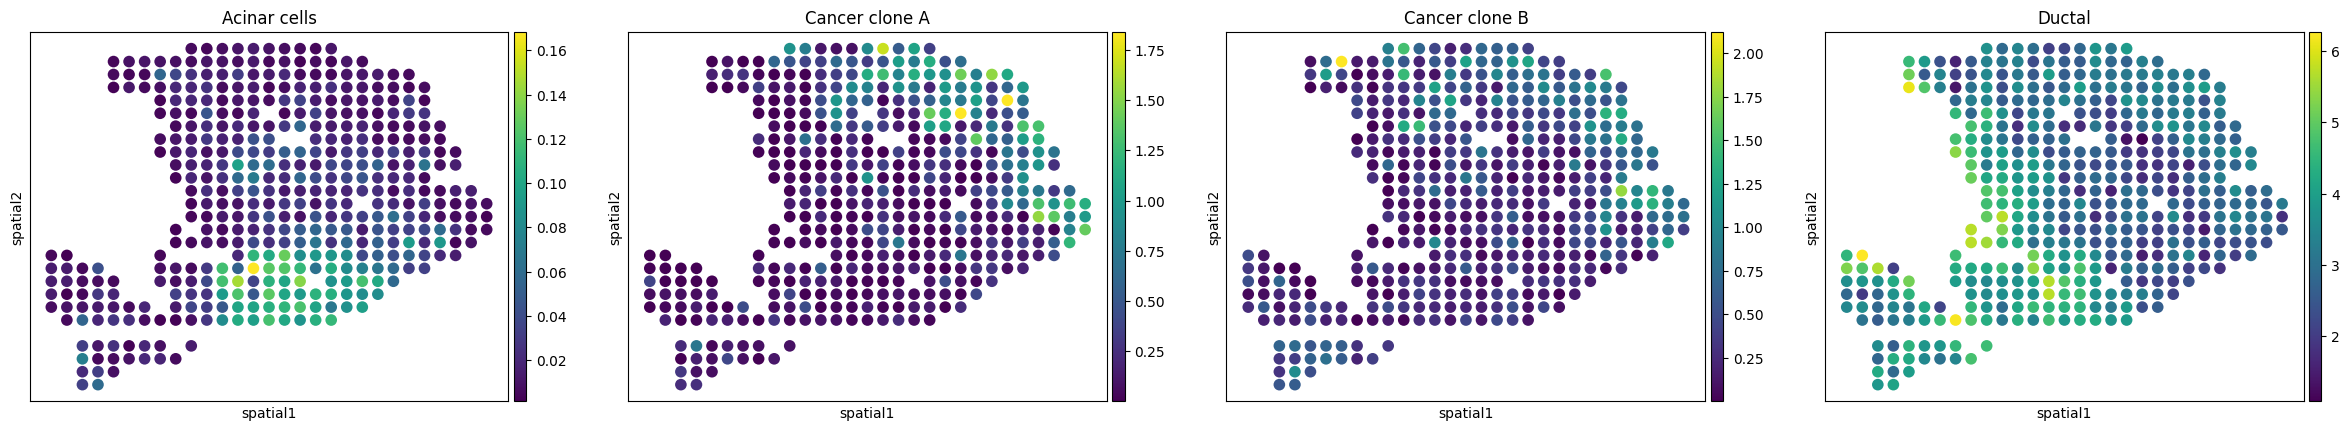

In [20]:
# Create a spatial scatter plot showing the distribution of different cell types
sc.pl.embedding(
    adata_st,
    basis='spatial',
    color=['Acinar cells','Cancer clone A','Cancer clone B','Ductal'],
    # color='leiden'
    
)